For testing this Google collab notebook you will need a rectified image pairs, We have provided sample images and also weights.

Import all the required python modules.

In [ ]:
import os
import random
import torch
import argparse
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def convbn(in_planes, out_planes, kernel_size, stride, pad, dilation):

    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation = dilation, bias=False),
                         nn.BatchNorm2d(out_planes))


def convbn_3d(in_planes, out_planes, kernel_size, stride, pad):

    return nn.Sequential(nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, padding=pad, stride=stride,bias=False),
                         nn.BatchNorm3d(out_planes))

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride, downsample, pad, dilation):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Sequential(convbn(inplanes, planes, 3, stride, pad, dilation),
                                   nn.ReLU(inplace=True))

        self.conv2 = convbn(planes, planes, 3, 1, pad, dilation)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            x = self.downsample(x)

        out += x

        return out


This is the code for 2D Feature Extraction.


In [ ]:
class feature_extraction(nn.Module):
    def __init__(self):
        super(feature_extraction, self).__init__()
        self.inplanes = 32
        self.firstconv = nn.Sequential(convbn(3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1,1,1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2,1,1) 
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1,1,1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1,1,2)

        self.branch1 = nn.Sequential(nn.AvgPool2d((64, 64), stride=(64,64)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((32, 32), stride=(32,32)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((16, 16), stride=(16,16)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((8, 8), stride=(8,8)),
                                     convbn(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.lastconv = nn.Sequential(convbn(320, 128, 3, 1, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
           downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,1,None,pad,dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output      = self.firstconv(x)
        output      = self.layer1(output)
        output_raw  = self.layer2(output)
        output      = self.layer3(output_raw)
        output_skip = self.layer4(output)


        output_branch1 = self.branch1(output_skip)
        output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch2 = self.branch2(output_skip)
        output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch3 = self.branch3(output_skip)
        output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch4 = self.branch4(output_skip)
        output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_feature = torch.cat((output_raw, output_skip, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.lastconv(output_feature)

        return output_feature

This is the code for stacked hour glass module Its not the full 3D CNN module its just the hourglass part of that. The Full 3D CNN module is combined in PSMNet class.

In [ ]:
class hourglass(nn.Module):
    def __init__(self, inplanes):
        super(hourglass, self).__init__()

        self.conv1 = nn.Sequential(convbn_3d(inplanes, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))

        self.conv2 = convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1)

        self.conv3 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=2, pad=1),
                                   nn.ReLU(inplace=True))

        self.conv4 = nn.Sequential(convbn_3d(inplanes*2, inplanes*2, kernel_size=3, stride=1, pad=1),
                                   nn.ReLU(inplace=True))

        self.conv5 = nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes*2, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes*2)) #+conv2

        self.conv6 = nn.Sequential(nn.ConvTranspose3d(inplanes*2, inplanes, kernel_size=3, padding=1, output_padding=1, stride=2,bias=False),
                                   nn.BatchNorm3d(inplanes)) #+x

    def forward(self, x ,presqu, postsqu):
        
        out  = self.conv1(x) #in:1/4 out:1/8
        pre  = self.conv2(out) #in:1/8 out:1/8
        if postsqu is not None:
           pre = F.relu(pre + postsqu, inplace=True)
        else:
           pre = F.relu(pre, inplace=True)

        out  = self.conv3(pre) #in:1/8 out:1/16
        out  = self.conv4(out) #in:1/16 out:1/16

        if presqu is not None:
           post = F.relu(self.conv5(out)+presqu, inplace=True) #in:1/16 out:1/8
        else:
           post = F.relu(self.conv5(out)+pre, inplace=True) 

        out  = self.conv6(post)  #in:1/8 out:1/4

        return out, pre, post

In [ ]:
class disparityregression(nn.Module):
    def __init__(self, maxdisp):
        super(disparityregression, self).__init__()
        self.disp = torch.Tensor(np.reshape(np.array(range(maxdisp)),[1, maxdisp,1,1])).cuda()

    def forward(self, x):
        out = torch.sum(x*self.disp.data,1, keepdim=True)
        return out

This is the Code where every module comes together to work as the NN architecture and the training and testing can be done by calling this module.

In [ ]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp

        self.feature_extraction = feature_extraction()

        self.dres0 = nn.Sequential(convbn_3d(64, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True),
                                     convbn_3d(32, 32, 3, 1, 1),
                                     nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres2 = hourglass(32)

        self.dres3 = hourglass(32)

        self.dres4 = hourglass(32)

        self.classif1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        self.classif3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()


    def forward(self, left, right):

        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)


        #matching
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp//4,  refimg_fea.size()[2],  refimg_fea.size()[3]).zero_()).cuda()

        for i in range(self.maxdisp//4):
            if i > 0 :
             cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
             cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
             cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
             cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        cost = cost.contiguous()

        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0

        out1, pre1, post1 = self.dres2(cost0, None, None) 
        out1 = out1+cost0

        out2, pre2, post2 = self.dres3(out1, pre1, post1) 
        out2 = out2+cost0

        out3, pre3, post3 = self.dres4(out2, pre1, post2) 
        out3 = out3+cost0

        cost1 = self.classif1(out1)
        cost2 = self.classif2(out2) + cost1
        cost3 = self.classif3(out3) + cost2

        if self.training:
            cost1 = F.upsample(cost1, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
            cost2 = F.upsample(cost2, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')

            cost1 = torch.squeeze(cost1,1)
            pred1 = F.softmax(cost1,dim=1)
            pred1 = disparityregression(self.maxdisp)(pred1)

            cost2 = torch.squeeze(cost2,1)
            pred2 = F.softmax(cost2,dim=1)
            pred2 = disparityregression(self.maxdisp)(pred2)

        cost3 = F.upsample(cost3, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost3 = torch.squeeze(cost3,1)
        pred3 = F.softmax(cost3,dim=1)
        #For your information: This formulation 'softmax(c)' learned "similarity" 
        #while 'softmax(-c)' learned 'matching cost' as mentioned in the paper.
        #However, 'c' or '-c' do not affect the performance because feature-based cost volume provided flexibility.
        pred3 = disparityregression(self.maxdisp)(pred3)

        if self.training:
            return pred1, pred2, pred3
        else:
            return pred3

This is the code to test the PSMNet stacked hourglass version, From here the test_PSM can be called with various images to get the disparity map.

In [ ]:
def test(imgL,imgR):
        model.eval()

        if (cuda_present):
           imgL = imgL.cuda()
           imgR = imgR.cuda()     

        with torch.no_grad():
            disp = model(imgL,imgR)

        disp = torch.squeeze(disp)
        pred_disp = disp.data.cpu().numpy()

        return pred_disp


def test_PSM(left_image_path, rght_image_path):

        normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                            'std': [0.229, 0.224, 0.225]}
        infer_transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(**normal_mean_var)])    

        imgL_o = Image.open(left_image_path).convert('RGB')
        imgR_o = Image.open(rght_image_path).convert('RGB')

        imgL = infer_transform(imgL_o)
        imgR = infer_transform(imgR_o) 
       

        # pad to width and hight to 16 times
        if imgL.shape[1] % 16 != 0:
            times = imgL.shape[1]//16       
            top_pad = (times+1)*16 -imgL.shape[1]
        else:
            top_pad = 0

        if imgL.shape[2] % 16 != 0:
            times = imgL.shape[2]//16                       
            right_pad = (times+1)*16-imgL.shape[2]
        else:
            right_pad = 0    

        imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
        imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

        # start_time = time.time()
        pred_disp = test(imgL,imgR)
        # print('time = %.2f' %(time.time() - start_time))

        
        if top_pad !=0 and right_pad != 0:
            img = pred_disp[top_pad:,:-right_pad]
        elif top_pad ==0 and right_pad != 0:
            img = pred_disp[:,:-right_pad]
        elif top_pad !=0 and right_pad == 0:
            img = pred_disp[top_pad:,:]
        else:
            img = pred_disp
        
        img = (img*256).astype('uint16')
        img = Image.fromarray(img)
        # img.save('Test_disparity.png')
        return img

The Code where the images and pretrained weights are loaded and passed for testing.

In [ ]:

cuda_present = True
maxdisp = 192
# torch.manual_seed(1)
left_image_path = "./000274_left.png"
rght_image_path = "./000274_right.png"
pretrained_model_path = "./pretrained_model_KITTI2012.tar?raw=true";
model = PSMNet(maxdisp)
if(cuda_present):
  torch.cuda.manual_seed(1)
  model = nn.DataParallel(model)
  model.cuda()

state_dict = torch.load(pretrained_model_path)
model.load_state_dict(state_dict['state_dict'])
disp = test_PSM(left_image_path, rght_image_path)
disp = np.array(disp, dtype=np.float64)
disp = cv2.normalize(disp, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Code to Visualize the input and output.

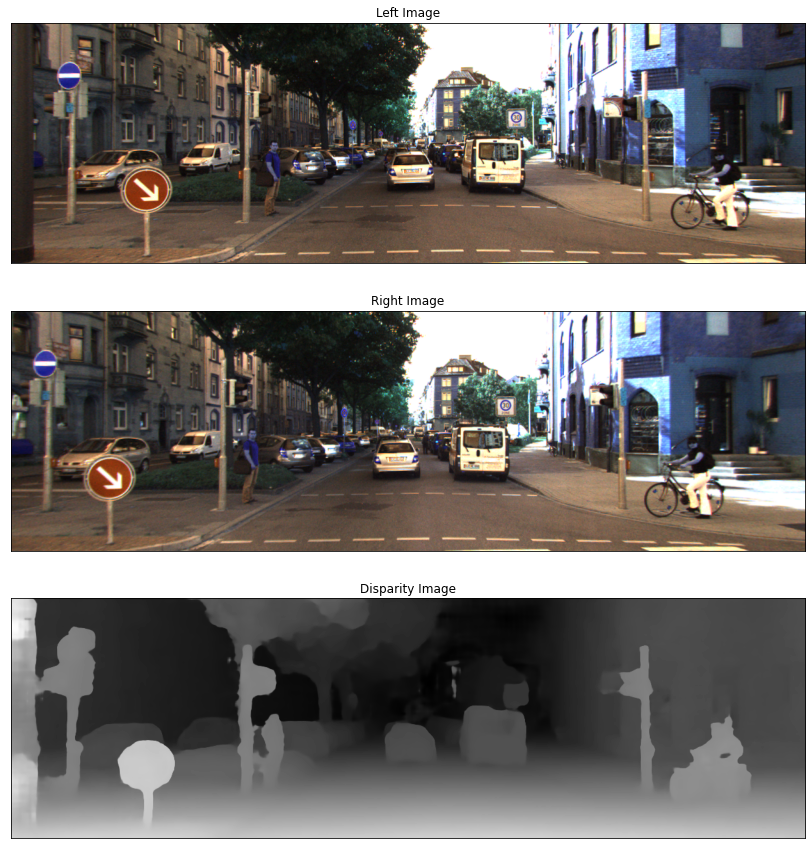

In [ ]:
left_image = cv2.imread(left_image_path)
rght_image = cv2.imread(rght_image_path)

f, axarr = plt.subplots(3,1, figsize=(15,15)) 
axarr[0].imshow(left_image)
axarr[0].set_title("Left Image")
axarr[0].axes.xaxis.set_visible(False)
axarr[0].axes.yaxis.set_visible(False)
axarr[1].imshow(rght_image)
axarr[1].set_title("Right Image")
axarr[1].axes.xaxis.set_visible(False)
axarr[1].axes.yaxis.set_visible(False)
axarr[2].imshow(disp, cmap="gray")
axarr[2].set_title("Disparity Image")
axarr[2].axes.xaxis.set_visible(False)
axarr[2].axes.yaxis.set_visible(False)
cv2.imwrite("./disparity.png", disp)
axarr[0].axes.xaxis.set_visible(False)
axarr[0].axes.yaxis.set_visible(False)
plt.show()